In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap

from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed

import sys
import os
from pathlib import Path
import pickle
import numpy as np
import time
import sklearn.model_selection as model_selection
from sklearn.decomposition import PCA
main_folder=str(Path.cwd().parent) 
sys.path.append(main_folder) 
data_folder = f'{main_folder}/data'

<ipython-input-2-66078832ac76>:12: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  aqua_globals.random_seed = seed


In [3]:
with open(f'DR16_processed_X.pkl','rb') as input_file:
    X = pickle.load(input_file)
with open(f'DR16_processed_y.pkl','rb') as input_file:
    y = pickle.load(input_file)

In [4]:
print(len(X))
print(len(y))

100000
100000


In [5]:
# Create binary target for 1st trial
y_star = y.apply(lambda x: "STAR" if x == "STAR" else "NOT_STAR")
class_labels_Star = list(set(y_star))
y_star_num =  y_star.apply(lambda x: 1 if x == "STAR" else 0)

In [6]:
#Create training_dataset and test_dataset with STAR and NOT_STAR
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_star_num, train_size=0.002, test_size=0.998, random_state=101)

# Create 1st test data
X_test_40 = X_test.iloc[:40].copy()
y_test_40 = y_test.iloc[:40].copy()

# 2nd test data 
X_test_extra = X_test.iloc[41:60].copy()
y_test_extra = y_test.iloc[41:60].copy()

print(X_train.shape)
print(X_test_40.shape)
print(X_test_extra.shape)

(200, 8)
(40, 8)
(19, 8)


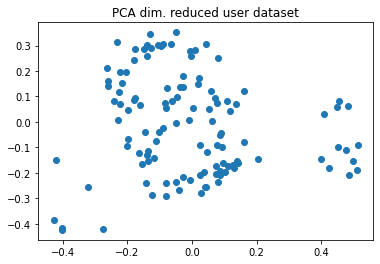

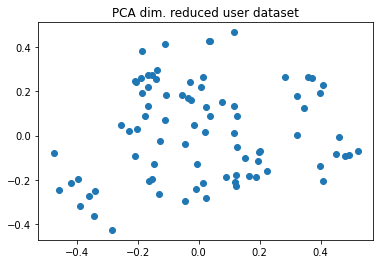

In [7]:
# Now reduce number of features to number of qubits
pca = PCA(n_components=2).fit(X_train)
X_train = pca.transform(X_train)
X_test_40 = pca.transform(X_test_40)
X_test_extra = pca.transform(X_test_extra)

# Create datapoint[X_test,y]
datapoints = [np.array(X_test_extra),np.array(y_test_extra)]
# If class labels are numeric
training_size = len(X_train)
test_size = len(X_test_40)
test_size_extra = len(X_test_extra)

#this is where I transform our dataframe to Dict[key:np.array]
if class_labels_Star[0].isdigit():
        # Pick training size number of samples from each distro
    training_input = {key: (X_train[y_train == int(key), :])[:training_size] for k, key in enumerate(class_labels_Star)}
    #test_input_extra = {key: (X_test_extra[y_test_extra == int(key), :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test_40[y_test == int(key), :])[: test_size] for k, key in enumerate(class_labels_Star)}
else:
    # if they aren't
    training_input = {key: (X_train[y_train == k, :])[:training_size] for k, key in enumerate(class_labels_Star)}
    #test_input_extra = {key: (X_test_extra[y_test_extra == k, :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test_40[y_test_40 == k, :])[:test_size] for k, key in enumerate(class_labels_Star)}

# Plot the 2 dimension result of PCA to check for correlation 
for k in range(0, 2):
    plt.scatter(X_train[y_train == k, 0][:training_size],
    X_train[y_train == k, 1][:training_size])
       
    plt.title("PCA dim. reduced user dataset")
    plt.show()   

In [8]:
print(len(training_input['STAR']))

117


In [9]:
feature_dim = 2

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
start_run_qsvm = time.time()
result = qsvm.run(quantum_instance)
end_run_qsvm = time.time()
print(f'run time is: {end_run_qsvm - start_run_qsvm}')

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/classifiers/qsvm/qsvm.py:102: DeprecationWarning: The package qiskit.aqua.algorithms.classifiers is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.classifiers (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.algorithms.classifiers',
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',


run time is: 993.1330006122589
Testing success ratio: 0.5

Prediction from datapoints set:
  ground truth: ['NOT_STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'STAR', 'STAR', 'STAR', 'STAR', 'STAR', 'NOT_STAR', 'STAR']
  prediction:   ['NOT_STAR', 'STAR', 'STAR', 'STAR', 'STAR', 'STAR', 'STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'STAR', 'NOT_STAR', 'NOT_STAR', 'STAR', 'STAR']
  success rate: 42.10526315789474%


In [10]:
def split_balanced(data, target, train_size=100, test_size=60):
    
    np.random.seed(0)

    classes = np.unique(target)
    # can give test_size as fraction of input data size of number of samples
    if test_size<1:
        n_test = np.round(len(target)*test_size)
    else:
        n_test = test_size
    n_train = train_size #max(0,len(target)-n_test)
    n_train_per_class = max(1,int(np.floor(n_train/len(classes))))
    n_test_per_class = max(1,int(np.floor(n_test/len(classes))))

    ixs = []
    for cl in classes:
        if (n_train_per_class+n_test_per_class) > np.sum(target==cl):
            # if data has too few samples for this class, do upsampling
            # split the data to training and testing before sampling so data points won't be
            #  shared among training and test data
            splitix = int(np.ceil(n_train_per_class/(n_train_per_class+n_test_per_class)*np.sum(target==cl)))
            ixs.append(np.r_[np.random.choice(np.nonzero(target==cl)[0][:splitix], n_train_per_class),
                np.random.choice(np.nonzero(target==cl)[0][splitix:], n_test_per_class)])
        else:
            ixs.append(np.random.choice(np.nonzero(target==cl)[0], n_train_per_class+n_test_per_class,
                replace=False))

    # take same num of samples from all classes
    ix_train = np.concatenate([x[:n_train_per_class] for x in ixs])
    ix_test = np.concatenate([x[n_train_per_class:(n_train_per_class+n_test_per_class)] for x in ixs])

    X_train = data[ix_train,:]
    X_test = data[ix_test,:]
    y_train = target[ix_train]
    y_test = target[ix_test]

    return X_train, X_test, y_train, y_test

In [11]:
prep = ZZFeatureMap(2, reps=2)
print(prep)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘


In [12]:
prep = ZZFeatureMap(2, reps=3)
print(prep)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           ┌───┐»
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
«     └──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ 

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_num = le.fit_transform(y.values)